In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
# Dataset imports:
from data.moleDataset import *

# Data augmenter imports:
from data.data_augmentation import*

# Torch imports:
import torch
import torch.nn as nn
from torch import optim
from torchvision import transforms
from torch.utils.data import Subset, DataLoader, random_split

# Model imports:
from model import *

# Train and evaluation imports:
from train import train
from evaluate import evaluate

# Plotting imports:
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure

# General imports:
import os
import json
import math

In [3]:
os.environ['KMP_DUPLICATE_LIB_OK'] = 'True'

### Defining the device

In [4]:
device = 'cpu'
if torch.cuda.is_available():
    device = 'cuda'
    print(f'Using: {torch.cuda.get_device_name(0)}')
print(f'Current device: {device}')

Using: NVIDIA GeForce GTX 1060 6GB
Current device: cuda


# Data preprocessing:

### Getting the mean and standard deviation of the dataset in order to apply normalization on the data:

In [5]:
# Getting the path to the .txt file that contains the mean and std:
DATA_STATS_FILE_NAME = "dataset_stats.txt"
STATS_FILE_PATH = os.path.join(os.path.dirname(os.path.abspath('__file__')), 'data', DATA_STATS_FILE_NAME)

# Reading the statistics file:
stats_dict = None
with open(STATS_FILE_PATH, 'r') as stats_file:
    stats_dict = json.loads(stats_file.read())
    
mean, std = stats_dict['mean'], stats_dict['std']

print(f'Dataset mean: \t\t\t{mean}\nDataset standard deviation: \t{std}')

Dataset mean: 			[0.4944856143767711, 0.4950292797617727, 0.4954058302766022]
Dataset standard deviation: 	[0.28984177278042145, 0.28989603043370027, 0.28941759149050483]


### Creating the preprocessing operations that the images will undergo:

In [6]:
# This Compose includes the following:
#     1) Transforms the images to tensors.
#     2) Normalized the dataset.
#     3) Sharpens the images.
image_preprocessing = transforms.Compose([
                            transforms.ToTensor(),
                            transforms.transforms.Normalize(mean, std),
                            lambda image : transforms.functional.adjust_sharpness(image,
                                                                                sharpness_factor=2)])

image_preprocessing = transforms.Compose([
                            transforms.ToTensor(),
                            transforms.transforms.Normalize(mean, std)])

# This transform is the same as the above one but it does not convert to Tensor
# So the returned image from the dataset can be visualized easier.
image_preprocessing_test = transforms.Compose([
                            transforms.transforms.Normalize(mean, std),
                            lambda image : transforms.functional.adjust_sharpness(image,
                                                                                sharpness_factor=2)])

# Defining the dataset:

In [37]:
# Creating the dataset instance:
test_dataset = MoleDataset(transform=image_preprocessing)

### The dataset class distribution:

In [38]:
data_dist = test_dataset.get_data_distribution()
data_dist

{'akiec': 327,
 'bcc': 514,
 'bkl': 1099,
 'df': 115,
 'mel': 1113,
 'nv': 6705,
 'vasc': 142}

### Plotting the data distribution:

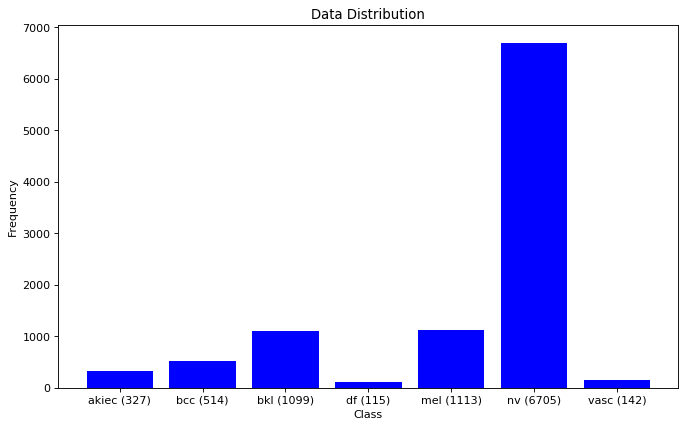

In [39]:
figure(figsize=(10, 6), dpi=80)
plt.title('Data Distribution')

y = list(data_dist.values())
x = [f'{label} ({count})' for label, count in zip(data_dist.keys(), data_dist.values())]

plt.xlabel("Class")
plt.ylabel("Frequency")
plt.bar(x, y, color='b')

plt.show()

# Overfitting Experiment:

### Creating a subset for training:

In [40]:
SUBSET_SIZE = 100
selected_class = 2
sample_array_1 = test_dataset.get_class_indecies(selected_class)

selected_class = 4
sample_array_2 = test_dataset.get_class_indecies(selected_class)

sample_array = sample_array_1 + sample_array_2

subset_indicies = np.random.choice(sample_array, SUBSET_SIZE, replace=False)
train_subset = Subset(test_dataset, subset_indicies)

In [41]:
subset_loader = DataLoader(train_subset, shuffle=True, batch_size=32)

### Creating the model:

In [44]:
model_overfit = SkinCancerModel()

### The hyperparameters, the loss function and the optimizer:

In [45]:
learning_rate = 1e-3
momentum = 0.9

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model_overfit.parameters(), lr=learning_rate, momentum=momentum)

In [46]:
epochs = 60

### Overfitting the model:

In [47]:
total_loss, epoch_durations, accuracies_train, accuracies_validation = train(model=model_overfit,
                                                                            train_loader=subset_loader,
                                                                            validation_loader=subset_loader,
                                                                            criterion=criterion,
                                                                            optimizer=optimizer,
                                                                            epochs=epochs,
                                                                            verbose=True)


  0%|          | 0/60 [00:00<?, ?it/s]

Evaluating epoch...



100%|██████████| 4/4 [00:05<00:00,  1.34s/it]

  2%|▏         | 1/60 [00:16<16:11, 16.47s/it]

Epoch: 0 | Train_acc: 17.00% | Val_acc: 17.00% | Loss: 10.26 | Runtime: 16.47 seconds
Evaluating epoch...



100%|██████████| 4/4 [00:05<00:00,  1.32s/it]

  3%|▎         | 2/60 [00:32<15:45, 16.31s/it]

Epoch: 1 | Train_acc: 12.00% | Val_acc: 12.00% | Loss: 8.09 | Runtime: 16.19 seconds
Evaluating epoch...



100%|██████████| 4/4 [00:05<00:00,  1.33s/it]

  5%|▌         | 3/60 [00:48<15:27, 16.27s/it]

Epoch: 2 | Train_acc: 66.00% | Val_acc: 66.00% | Loss: 6.17 | Runtime: 16.22 seconds
Evaluating epoch...



100%|██████████| 4/4 [00:05<00:00,  1.40s/it]

  7%|▋         | 4/60 [01:05<15:24, 16.51s/it]

Epoch: 3 | Train_acc: 66.00% | Val_acc: 66.00% | Loss: 4.73 | Runtime: 16.89 seconds
Evaluating epoch...



100%|██████████| 4/4 [00:05<00:00,  1.33s/it]

  8%|▊         | 5/60 [01:21<15:01, 16.38s/it]

Epoch: 4 | Train_acc: 67.00% | Val_acc: 67.00% | Loss: 5.53 | Runtime: 16.16 seconds
Evaluating epoch...



100%|██████████| 4/4 [00:05<00:00,  1.34s/it]

 10%|█         | 6/60 [01:38<14:42, 16.35s/it]

Epoch: 5 | Train_acc: 66.00% | Val_acc: 66.00% | Loss: 3.57 | Runtime: 16.27 seconds
Evaluating epoch...



100%|██████████| 4/4 [00:05<00:00,  1.37s/it]

 12%|█▏        | 7/60 [01:54<14:28, 16.38s/it]

Epoch: 6 | Train_acc: 67.00% | Val_acc: 67.00% | Loss: 4.58 | Runtime: 16.46 seconds
Evaluating epoch...



100%|██████████| 4/4 [00:05<00:00,  1.34s/it]

 13%|█▎        | 8/60 [02:10<14:09, 16.33s/it]

Epoch: 7 | Train_acc: 69.00% | Val_acc: 69.00% | Loss: 4.03 | Runtime: 16.22 seconds
Evaluating epoch...



100%|██████████| 4/4 [00:05<00:00,  1.33s/it]

 15%|█▌        | 9/60 [02:27<13:50, 16.28s/it]

Epoch: 8 | Train_acc: 70.00% | Val_acc: 70.00% | Loss: 3.02 | Runtime: 16.16 seconds
Evaluating epoch...



100%|██████████| 4/4 [00:05<00:00,  1.34s/it]

 17%|█▋        | 10/60 [02:43<13:33, 16.27s/it]

Epoch: 9 | Train_acc: 70.00% | Val_acc: 70.00% | Loss: 2.94 | Runtime: 16.25 seconds
Evaluating epoch...



100%|██████████| 4/4 [00:05<00:00,  1.33s/it]

 18%|█▊        | 11/60 [02:59<13:15, 16.24s/it]

Epoch: 10 | Train_acc: 70.00% | Val_acc: 70.00% | Loss: 2.93 | Runtime: 16.17 seconds
Evaluating epoch...



100%|██████████| 4/4 [00:05<00:00,  1.33s/it]

 20%|██        | 12/60 [03:15<12:58, 16.22s/it]

Epoch: 11 | Train_acc: 72.00% | Val_acc: 72.00% | Loss: 3.67 | Runtime: 16.17 seconds
Evaluating epoch...



100%|██████████| 4/4 [00:05<00:00,  1.37s/it]

 22%|██▏       | 13/60 [03:31<12:43, 16.25s/it]

Epoch: 12 | Train_acc: 72.00% | Val_acc: 72.00% | Loss: 2.78 | Runtime: 16.34 seconds
Evaluating epoch...



100%|██████████| 4/4 [00:05<00:00,  1.33s/it]

 23%|██▎       | 14/60 [03:48<12:27, 16.24s/it]

Epoch: 13 | Train_acc: 72.00% | Val_acc: 72.00% | Loss: 3.41 | Runtime: 16.21 seconds
Evaluating epoch...



100%|██████████| 4/4 [00:05<00:00,  1.33s/it]

 25%|██▌       | 15/60 [04:04<12:12, 16.27s/it]

Epoch: 14 | Train_acc: 72.00% | Val_acc: 72.00% | Loss: 2.56 | Runtime: 16.35 seconds
Evaluating epoch...



100%|██████████| 4/4 [00:05<00:00,  1.32s/it]

 27%|██▋       | 16/60 [04:20<11:56, 16.29s/it]

Epoch: 15 | Train_acc: 74.00% | Val_acc: 74.00% | Loss: 2.84 | Runtime: 16.33 seconds
Evaluating epoch...



100%|██████████| 4/4 [00:05<00:00,  1.33s/it]

 28%|██▊       | 17/60 [04:37<11:39, 16.26s/it]

Epoch: 16 | Train_acc: 75.00% | Val_acc: 75.00% | Loss: 3.11 | Runtime: 16.18 seconds
Evaluating epoch...



100%|██████████| 4/4 [00:05<00:00,  1.33s/it]

 30%|███       | 18/60 [04:53<11:21, 16.24s/it]

Epoch: 17 | Train_acc: 75.00% | Val_acc: 75.00% | Loss: 2.66 | Runtime: 16.18 seconds
Evaluating epoch...



100%|██████████| 4/4 [00:05<00:00,  1.37s/it]

 32%|███▏      | 19/60 [05:09<11:07, 16.28s/it]

Epoch: 18 | Train_acc: 77.00% | Val_acc: 77.00% | Loss: 2.42 | Runtime: 16.38 seconds
Evaluating epoch...



100%|██████████| 4/4 [00:05<00:00,  1.33s/it]

 33%|███▎      | 20/60 [05:25<10:50, 16.27s/it]

Epoch: 19 | Train_acc: 79.00% | Val_acc: 79.00% | Loss: 2.94 | Runtime: 16.24 seconds
Evaluating epoch...



100%|██████████| 4/4 [00:05<00:00,  1.34s/it]

 35%|███▌      | 21/60 [05:42<10:34, 16.27s/it]

Epoch: 20 | Train_acc: 80.00% | Val_acc: 80.00% | Loss: 2.21 | Runtime: 16.27 seconds
Evaluating epoch...



100%|██████████| 4/4 [00:05<00:00,  1.37s/it]

 37%|███▋      | 22/60 [05:58<10:19, 16.31s/it]

Epoch: 21 | Train_acc: 82.00% | Val_acc: 82.00% | Loss: 2.27 | Runtime: 16.40 seconds
Evaluating epoch...



100%|██████████| 4/4 [00:05<00:00,  1.38s/it]

 38%|███▊      | 23/60 [06:15<10:08, 16.44s/it]

Epoch: 22 | Train_acc: 84.00% | Val_acc: 84.00% | Loss: 2.31 | Runtime: 16.75 seconds
Evaluating epoch...



100%|██████████| 4/4 [00:05<00:00,  1.32s/it]

 40%|████      | 24/60 [06:31<09:49, 16.37s/it]

Epoch: 23 | Train_acc: 85.00% | Val_acc: 85.00% | Loss: 2.24 | Runtime: 16.21 seconds
Evaluating epoch...



100%|██████████| 4/4 [00:05<00:00,  1.36s/it]

 42%|████▏     | 25/60 [06:47<09:32, 16.37s/it]

Epoch: 24 | Train_acc: 85.00% | Val_acc: 85.00% | Loss: 2.19 | Runtime: 16.36 seconds
Evaluating epoch...



100%|██████████| 4/4 [00:05<00:00,  1.33s/it]

 43%|████▎     | 26/60 [07:04<09:15, 16.34s/it]

Epoch: 25 | Train_acc: 84.00% | Val_acc: 84.00% | Loss: 2.01 | Runtime: 16.28 seconds
Evaluating epoch...



100%|██████████| 4/4 [00:05<00:00,  1.32s/it]

 45%|████▌     | 27/60 [07:20<08:58, 16.31s/it]

Epoch: 26 | Train_acc: 79.00% | Val_acc: 79.00% | Loss: 1.81 | Runtime: 16.21 seconds
Evaluating epoch...



100%|██████████| 4/4 [00:05<00:00,  1.33s/it]

 47%|████▋     | 28/60 [07:36<08:41, 16.29s/it]

Epoch: 27 | Train_acc: 87.00% | Val_acc: 87.00% | Loss: 2.17 | Runtime: 16.25 seconds
Evaluating epoch...



100%|██████████| 4/4 [00:05<00:00,  1.33s/it]

 48%|████▊     | 29/60 [07:52<08:24, 16.28s/it]

Epoch: 28 | Train_acc: 88.00% | Val_acc: 88.00% | Loss: 1.91 | Runtime: 16.24 seconds
Evaluating epoch...



100%|██████████| 4/4 [00:05<00:00,  1.37s/it]

 50%|█████     | 30/60 [08:09<08:09, 16.30s/it]

Epoch: 29 | Train_acc: 87.00% | Val_acc: 87.00% | Loss: 1.67 | Runtime: 16.36 seconds
Evaluating epoch...



100%|██████████| 4/4 [00:05<00:00,  1.33s/it]

 52%|█████▏    | 31/60 [08:25<07:52, 16.28s/it]

Epoch: 30 | Train_acc: 87.00% | Val_acc: 87.00% | Loss: 2.08 | Runtime: 16.24 seconds
Evaluating epoch...



100%|██████████| 4/4 [00:05<00:00,  1.33s/it]

 53%|█████▎    | 32/60 [08:41<07:35, 16.27s/it]

Epoch: 31 | Train_acc: 89.00% | Val_acc: 89.00% | Loss: 1.53 | Runtime: 16.24 seconds
Evaluating epoch...



100%|██████████| 4/4 [00:05<00:00,  1.33s/it]

 55%|█████▌    | 33/60 [08:57<07:18, 16.25s/it]

Epoch: 32 | Train_acc: 91.00% | Val_acc: 91.00% | Loss: 1.64 | Runtime: 16.21 seconds
Evaluating epoch...



100%|██████████| 4/4 [00:05<00:00,  1.38s/it]

 57%|█████▋    | 34/60 [09:14<07:03, 16.30s/it]

Epoch: 33 | Train_acc: 85.00% | Val_acc: 85.00% | Loss: 1.57 | Runtime: 16.41 seconds
Evaluating epoch...



100%|██████████| 4/4 [00:05<00:00,  1.33s/it]

 58%|█████▊    | 35/60 [09:30<06:46, 16.27s/it]

Epoch: 34 | Train_acc: 89.00% | Val_acc: 89.00% | Loss: 1.62 | Runtime: 16.19 seconds
Evaluating epoch...



100%|██████████| 4/4 [00:05<00:00,  1.34s/it]

 60%|██████    | 36/60 [09:46<06:31, 16.29s/it]

Epoch: 35 | Train_acc: 92.00% | Val_acc: 92.00% | Loss: 1.40 | Runtime: 16.36 seconds
Evaluating epoch...



100%|██████████| 4/4 [00:05<00:00,  1.41s/it]

 62%|██████▏   | 37/60 [10:03<06:16, 16.39s/it]

Epoch: 36 | Train_acc: 88.00% | Val_acc: 88.00% | Loss: 1.81 | Runtime: 16.60 seconds
Evaluating epoch...



100%|██████████| 4/4 [00:05<00:00,  1.33s/it]

 63%|██████▎   | 38/60 [10:19<05:59, 16.35s/it]

Epoch: 37 | Train_acc: 91.00% | Val_acc: 91.00% | Loss: 1.38 | Runtime: 16.26 seconds
Evaluating epoch...



100%|██████████| 4/4 [00:05<00:00,  1.40s/it]

 65%|██████▌   | 39/60 [10:36<05:44, 16.38s/it]

Epoch: 38 | Train_acc: 89.00% | Val_acc: 89.00% | Loss: 1.33 | Runtime: 16.47 seconds
Evaluating epoch...



100%|██████████| 4/4 [00:05<00:00,  1.35s/it]

 67%|██████▋   | 40/60 [10:52<05:27, 16.36s/it]

Epoch: 39 | Train_acc: 87.00% | Val_acc: 87.00% | Loss: 1.18 | Runtime: 16.31 seconds
Evaluating epoch...



100%|██████████| 4/4 [00:05<00:00,  1.33s/it]

 68%|██████▊   | 41/60 [11:08<05:10, 16.33s/it]

Epoch: 40 | Train_acc: 91.00% | Val_acc: 91.00% | Loss: 1.44 | Runtime: 16.25 seconds
Evaluating epoch...



100%|██████████| 4/4 [00:05<00:00,  1.33s/it]

 70%|███████   | 42/60 [11:24<04:53, 16.29s/it]

Epoch: 41 | Train_acc: 93.00% | Val_acc: 93.00% | Loss: 1.68 | Runtime: 16.20 seconds
Evaluating epoch...



100%|██████████| 4/4 [00:05<00:00,  1.38s/it]

 72%|███████▏  | 43/60 [11:41<04:37, 16.34s/it]

Epoch: 42 | Train_acc: 94.00% | Val_acc: 94.00% | Loss: 1.12 | Runtime: 16.47 seconds
Evaluating epoch...



100%|██████████| 4/4 [00:05<00:00,  1.33s/it]

 73%|███████▎  | 44/60 [11:57<04:21, 16.34s/it]

Epoch: 43 | Train_acc: 91.00% | Val_acc: 91.00% | Loss: 1.11 | Runtime: 16.33 seconds
Evaluating epoch...



100%|██████████| 4/4 [00:05<00:00,  1.33s/it]

 75%|███████▌  | 45/60 [12:13<04:04, 16.31s/it]

Epoch: 44 | Train_acc: 93.00% | Val_acc: 93.00% | Loss: 1.33 | Runtime: 16.23 seconds
Evaluating epoch...



100%|██████████| 4/4 [00:05<00:00,  1.36s/it]

 77%|███████▋  | 46/60 [12:30<03:48, 16.30s/it]

Epoch: 45 | Train_acc: 92.00% | Val_acc: 92.00% | Loss: 1.14 | Runtime: 16.29 seconds
Evaluating epoch...



100%|██████████| 4/4 [00:05<00:00,  1.32s/it]

 78%|███████▊  | 47/60 [12:46<03:31, 16.29s/it]

Epoch: 46 | Train_acc: 93.00% | Val_acc: 93.00% | Loss: 1.07 | Runtime: 16.25 seconds
Evaluating epoch...



100%|██████████| 4/4 [00:05<00:00,  1.33s/it]

 80%|████████  | 48/60 [13:02<03:15, 16.29s/it]

Epoch: 47 | Train_acc: 94.00% | Val_acc: 94.00% | Loss: 1.03 | Runtime: 16.30 seconds
Evaluating epoch...



100%|██████████| 4/4 [00:05<00:00,  1.37s/it]

 82%|████████▏ | 49/60 [13:19<02:59, 16.32s/it]

Epoch: 48 | Train_acc: 94.00% | Val_acc: 94.00% | Loss: 1.13 | Runtime: 16.38 seconds
Evaluating epoch...



100%|██████████| 4/4 [00:05<00:00,  1.33s/it]

 83%|████████▎ | 50/60 [13:35<02:43, 16.30s/it]

Epoch: 49 | Train_acc: 93.00% | Val_acc: 93.00% | Loss: 1.20 | Runtime: 16.26 seconds
Evaluating epoch...



100%|██████████| 4/4 [00:05<00:00,  1.34s/it]

 85%|████████▌ | 51/60 [13:51<02:26, 16.33s/it]

Epoch: 50 | Train_acc: 95.00% | Val_acc: 95.00% | Loss: 1.34 | Runtime: 16.39 seconds
Evaluating epoch...



100%|██████████| 4/4 [00:05<00:00,  1.36s/it]

 87%|████████▋ | 52/60 [14:08<02:10, 16.32s/it]

Epoch: 51 | Train_acc: 89.00% | Val_acc: 89.00% | Loss: 0.76 | Runtime: 16.30 seconds
Evaluating epoch...



100%|██████████| 4/4 [00:05<00:00,  1.33s/it]

 88%|████████▊ | 53/60 [14:24<01:54, 16.30s/it]

Epoch: 52 | Train_acc: 95.00% | Val_acc: 95.00% | Loss: 1.11 | Runtime: 16.25 seconds
Evaluating epoch...



100%|██████████| 4/4 [00:05<00:00,  1.32s/it]

 90%|█████████ | 54/60 [14:40<01:37, 16.26s/it]

Epoch: 53 | Train_acc: 90.00% | Val_acc: 90.00% | Loss: 1.09 | Runtime: 16.16 seconds
Evaluating epoch...



100%|██████████| 4/4 [00:05<00:00,  1.37s/it]

 92%|█████████▏| 55/60 [14:56<01:21, 16.31s/it]

Epoch: 54 | Train_acc: 96.00% | Val_acc: 96.00% | Loss: 1.12 | Runtime: 16.42 seconds
Evaluating epoch...



100%|██████████| 4/4 [00:05<00:00,  1.33s/it]

 93%|█████████▎| 56/60 [15:13<01:05, 16.27s/it]

Epoch: 55 | Train_acc: 89.00% | Val_acc: 89.00% | Loss: 0.74 | Runtime: 16.19 seconds
Evaluating epoch...



100%|██████████| 4/4 [00:05<00:00,  1.33s/it]

 95%|█████████▌| 57/60 [15:29<00:48, 16.27s/it]

Epoch: 56 | Train_acc: 95.00% | Val_acc: 95.00% | Loss: 0.92 | Runtime: 16.27 seconds
Evaluating epoch...



100%|██████████| 4/4 [00:05<00:00,  1.42s/it]

 97%|█████████▋| 58/60 [15:45<00:32, 16.36s/it]

Epoch: 57 | Train_acc: 97.00% | Val_acc: 97.00% | Loss: 0.56 | Runtime: 16.56 seconds
Evaluating epoch...



100%|██████████| 4/4 [00:05<00:00,  1.32s/it]

 98%|█████████▊| 59/60 [16:02<00:16, 16.31s/it]

Epoch: 58 | Train_acc: 97.00% | Val_acc: 97.00% | Loss: 0.62 | Runtime: 16.20 seconds
Evaluating epoch...



100%|██████████| 4/4 [00:05<00:00,  1.33s/it]

100%|██████████| 60/60 [16:18<00:00, 16.31s/it]

Epoch: 59 | Train_acc: 95.00% | Val_acc: 95.00% | Loss: 0.75 | Runtime: 16.25 seconds


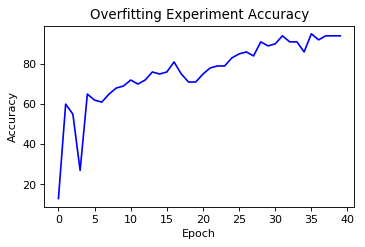

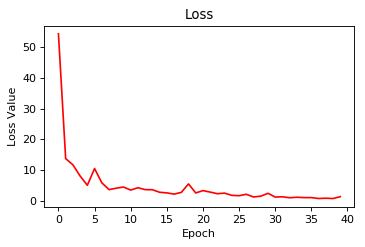

In [31]:
figure(figsize=(5, 3), dpi=80)
plt.title('Overfitting Experiment Accuracy')

plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.plot(accuracies_train, color='b')

plt.show()

figure(figsize=(5, 3), dpi=80)
plt.title('Loss')
plt.xlabel("Epoch")
plt.ylabel("Loss Value")
plt.plot(total_loss, color='r')
plt.show()

# Setting up the actual model:

### Defining the Dataset object:

In [7]:
dataset = MoleDataset(transform=image_preprocessing)

### Splitting the dataset into train, validation, and test sets:

In [8]:
# Defining the proportions of how the dataset will be split:
train_proportion = 0.8
validation_proportion = 0.1
test_proportion = 0.1

# Defining the sizes of the splits:

# 1) The train set size:
train_size = math.ceil(train_proportion * len(dataset))

# 2) The validation set size:
validation_size = math.ceil(validation_proportion * len(dataset))

# 3) The test set size:
test_size = math.floor(test_proportion * len(dataset))

# Defining the indecies of the train, validation and test sets:
all_indecies = np.random.choice(list(range(len(dataset))), (10, len(dataset) // 10), replace=False)

train_set_ind = np.random.choice(list(range(all_indecies.shape[0])), int(train_proportion * 10), replace=False)
val_set_ind = np.random.choice(list(range(all_indecies.shape[0])), int(validation_proportion * 10), replace=False)
test_set_ind = np.random.choice(list(range(all_indecies.shape[0])), int(test_proportion * 10), replace=False)

train_set_ind = np.append([], all_indecies[train_set_ind]).astype(np.int)
val_set_ind = np.append([], all_indecies[val_set_ind]).astype(np.int)
test_set_ind = np.append([], all_indecies[test_set_ind]).astype(np.int)

# # Defining the train, validation, and test sets:
class_threshold = 1000
train_set = MoleDataset(transform=image_preprocessing, indecies=train_set_ind, class_threshold=class_threshold)
validation_set = MoleDataset(transform=image_preprocessing, indecies=val_set_ind)
test_set = MoleDataset(transform=image_preprocessing, indecies=test_set_ind)

In [9]:
data_dist = train_set.get_data_distribution()
print(len(train_set))
data_dist

3653


{'akiec': 252,
 'bcc': 420,
 'bkl': 892,
 'df': 101,
 'mel': 876,
 'nv': 1000,
 'vasc': 112}

### Plotting the train data distribution before augmentation

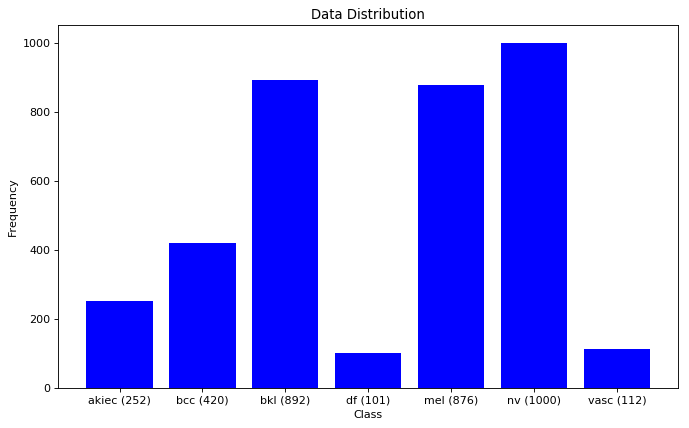

In [10]:
figure(figsize=(10, 6), dpi=80)
plt.title('Data Distribution')

y = list(data_dist.values())
x = [f'{label} ({count})' for label, count in zip(data_dist.keys(), data_dist.values())]

plt.xlabel("Class")
plt.ylabel("Frequency")
plt.bar(x, y, color='b')

plt.show()

# Augmenting the training data:

In [11]:
augmentation_amount = [class_threshold - i for i in data_dist.values()]
print(f'Number of data points to be augmented: {sum(augmentation_amount)}')
augmentation_amount

Number of data points to be augmented: 3347


[748, 580, 108, 899, 124, 0, 888]

In [125]:
# Getting the path where the augmented data will be placed:
augmention_path_location = os.path.join(os.path.dirname(os.path.abspath("__file__")), 'data', 'dataset_location.txt')
augmentation_path = None
with open(augmention_path_location, 'r') as file:
    augmentation_path = json.loads(file.read())
    augmentation_path = augmentation_path['aug_data']
    
augmenter = DataAugmenter(dataset=train_set, augmentation_path=augmentation_path)
augmenter.augment_multiple_classes(list(train_set.mapping.keys()), augmentation_amount, replace=True)

Cannot delete the augmented images due to at least one of the following reasons:
1) The augemented images' folder contains a file that is not an augmented image or the metadata csv file.
2) The augemented images' folder does not contain any augmented image.
3) The augmented images' folder does not contain the metadatacsv file

class: akiec | amount augmented: 735
class: bcc | amount augmented: 570
class: bkl | amount augmented: 145
class: df | amount augmented: 905
class: mel | amount augmented: 126
class: nv | amount augmented: 0
class: vasc | amount augmented: 888


In [12]:
# train_set = MoleDataset(transform=image_preprocessing, indecies=train_set_ind, augment=True)
train_set = MoleDataset(transform=image_preprocessing, indecies=train_set_ind, augment=True, class_threshold=class_threshold)

In [13]:
data_dist = train_set.get_data_distribution()
data_dist

{'akiec': 959,
 'bcc': 990,
 'bkl': 996,
 'df': 1000,
 'mel': 996,
 'nv': 1036,
 'vasc': 1000}

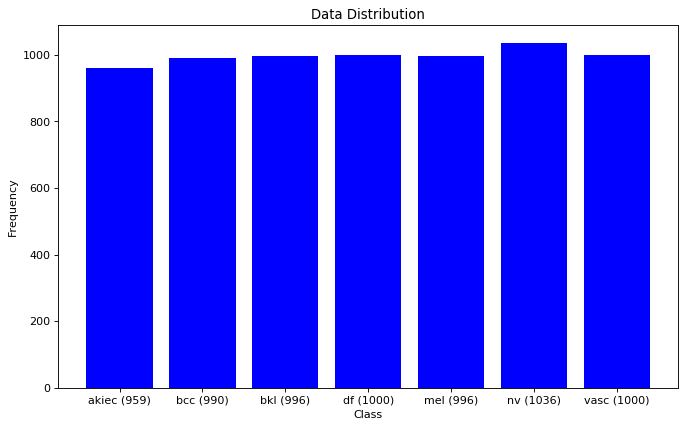

In [14]:
figure(figsize=(10, 6), dpi=80)
plt.title('Data Distribution')

y = list(data_dist.values())
x = [f'{label} ({count})' for label, count in zip(data_dist.keys(), data_dist.values())]

plt.xlabel("Class")
plt.ylabel("Frequency")
plt.bar(x, y, color='b')

plt.show()

### Creating the DataLoader objects:

In [15]:
train_batch_size, validation_batch_size, test_batch_size = 8, 8, 16

# Setting the num_workers to the number of cores on this machine.
num_workers = 4

train_loader = DataLoader(train_set, shuffle=True, batch_size=train_batch_size, num_workers=num_workers)
validation_loader = DataLoader(validation_set, shuffle=True, batch_size=validation_batch_size, num_workers=num_workers)
test_loader = DataLoader(test_set, shuffle=True, batch_size=test_batch_size, num_workers=num_workers)

### Creating the model:

In [28]:
model = SkinCancerModel()

### Defining the optimizer, criterion, and hyperparameters:

In [29]:
learning_rate = 1e-3 # 1e-3 in the previous trial.

# Getting the classes weights:
# loss_weights = torch.tensor(dataset.class_weights(), dtype=torch.float)

# Defining the optimizer:
optimizer = optim.SGD(model.parameters(), lr=learning_rate)

# Defining the learning rate schedular:
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=20, gamma=0.1) # None in the previous trial.
# scheduler = None

# Defining the weighted loss function:
# criterion = nn.CrossEntropyLoss(weight=loss_weights)
criterion = nn.CrossEntropyLoss()
criterion = criterion.to(device=device)

### Defining the number of epochs:

In [30]:
epochs = 45 # 10 in the previous trial.

# Training the model

In [31]:
total_loss, epoch_durations, accuracies_train, accuracies_validation = train(model=model,
                                                                            train_loader=train_loader,
                                                                            validation_loader=validation_loader,
                                                                            criterion=criterion,
                                                                            optimizer=optimizer,
                                                                            scheduler=scheduler,
                                                                            epochs=epochs,
                                                                            verbose=True)

  0%|          | 0/45 [00:00<?, ?it/s]

Evaluating epoch...


  2%|▏         | 1/45 [01:34<1:09:03, 94.17s/it]

Learning rate: 0.001
Epoch: 0 | Train_acc: 23.68% | Val_acc: 51.65% | Loss: 2106.57 | Runtime: 94.17 seconds
Evaluating epoch...


  4%|▍         | 2/45 [03:05<1:06:24, 92.67s/it]

Learning rate: 0.001
Epoch: 1 | Train_acc: 45.52% | Val_acc: 46.65% | Loss: 1257.12 | Runtime: 91.63 seconds
Evaluating epoch...


  7%|▋         | 3/45 [04:38<1:04:43, 92.47s/it]

Learning rate: 0.001
Epoch: 2 | Train_acc: 49.41% | Val_acc: 45.55% | Loss: 1137.22 | Runtime: 92.24 seconds
Evaluating epoch...


  9%|▉         | 4/45 [06:09<1:02:58, 92.15s/it]

Learning rate: 0.001
Epoch: 3 | Train_acc: 52.42% | Val_acc: 50.55% | Loss: 1064.23 | Runtime: 91.66 seconds
Evaluating epoch...


 11%|█         | 5/45 [07:41<1:01:15, 91.89s/it]

Learning rate: 0.001
Epoch: 4 | Train_acc: 51.37% | Val_acc: 55.84% | Loss: 1001.07 | Runtime: 91.42 seconds
Evaluating epoch...


 13%|█▎        | 6/45 [09:12<59:37, 91.74s/it]  

Learning rate: 0.001
Epoch: 5 | Train_acc: 60.90% | Val_acc: 55.64% | Loss: 949.53 | Runtime: 91.45 seconds
Evaluating epoch...


 16%|█▌        | 7/45 [10:43<57:59, 91.55s/it]

Learning rate: 0.001
Epoch: 6 | Train_acc: 59.91% | Val_acc: 62.24% | Loss: 900.26 | Runtime: 91.17 seconds
Evaluating epoch...


 18%|█▊        | 8/45 [12:14<56:12, 91.15s/it]

Learning rate: 0.001
Epoch: 7 | Train_acc: 66.26% | Val_acc: 66.53% | Loss: 860.94 | Runtime: 90.28 seconds
Evaluating epoch...


 20%|██        | 9/45 [13:44<54:29, 90.83s/it]

Learning rate: 0.001
Epoch: 8 | Train_acc: 63.41% | Val_acc: 68.73% | Loss: 827.04 | Runtime: 90.12 seconds
Evaluating epoch...


 22%|██▏       | 10/45 [15:14<52:53, 90.67s/it]

Learning rate: 0.001
Epoch: 9 | Train_acc: 64.45% | Val_acc: 71.43% | Loss: 797.40 | Runtime: 90.32 seconds
Evaluating epoch...


 24%|██▍       | 11/45 [16:44<51:16, 90.50s/it]

Learning rate: 0.001
Epoch: 10 | Train_acc: 67.78% | Val_acc: 65.63% | Loss: 768.24 | Runtime: 90.11 seconds
Evaluating epoch...


 27%|██▋       | 12/45 [18:14<49:44, 90.43s/it]

Learning rate: 0.001
Epoch: 11 | Train_acc: 69.14% | Val_acc: 72.13% | Loss: 739.49 | Runtime: 90.27 seconds
Evaluating epoch...


 29%|██▉       | 13/45 [19:45<48:12, 90.38s/it]

Learning rate: 0.001
Epoch: 12 | Train_acc: 70.04% | Val_acc: 60.84% | Loss: 718.49 | Runtime: 90.27 seconds
Evaluating epoch...


 31%|███       | 14/45 [21:15<46:40, 90.32s/it]

Learning rate: 0.001
Epoch: 13 | Train_acc: 66.68% | Val_acc: 56.04% | Loss: 696.67 | Runtime: 90.19 seconds
Evaluating epoch...


 33%|███▎      | 15/45 [22:45<45:08, 90.27s/it]

Learning rate: 0.001
Epoch: 14 | Train_acc: 71.85% | Val_acc: 71.73% | Loss: 670.95 | Runtime: 90.15 seconds
Evaluating epoch...


 36%|███▌      | 16/45 [24:15<43:37, 90.25s/it]

Learning rate: 0.001
Epoch: 15 | Train_acc: 73.81% | Val_acc: 66.83% | Loss: 651.15 | Runtime: 90.19 seconds
Evaluating epoch...


 38%|███▊      | 17/45 [25:45<42:06, 90.24s/it]

Learning rate: 0.001
Epoch: 16 | Train_acc: 77.01% | Val_acc: 70.33% | Loss: 634.81 | Runtime: 90.23 seconds
Evaluating epoch...


 40%|████      | 18/45 [27:15<40:35, 90.21s/it]

Learning rate: 0.001
Epoch: 17 | Train_acc: 74.47% | Val_acc: 65.33% | Loss: 611.99 | Runtime: 90.13 seconds
Evaluating epoch...


 42%|████▏     | 19/45 [28:46<39:07, 90.27s/it]

Learning rate: 0.001
Epoch: 18 | Train_acc: 76.94% | Val_acc: 72.43% | Loss: 597.69 | Runtime: 90.42 seconds
Evaluating epoch...


 44%|████▍     | 20/45 [30:16<37:34, 90.17s/it]

Learning rate: 0.001
Epoch: 19 | Train_acc: 78.76% | Val_acc: 74.13% | Loss: 581.21 | Runtime: 89.94 seconds
Evaluating epoch...


 47%|████▋     | 21/45 [31:46<36:04, 90.20s/it]

Learning rate: 0.0001
Epoch: 20 | Train_acc: 80.44% | Val_acc: 71.33% | Loss: 516.76 | Runtime: 90.25 seconds
Evaluating epoch...


 49%|████▉     | 22/45 [33:16<34:34, 90.21s/it]

Learning rate: 0.0001
Epoch: 21 | Train_acc: 80.31% | Val_acc: 68.93% | Loss: 510.59 | Runtime: 90.23 seconds
Evaluating epoch...


 51%|█████     | 23/45 [34:47<33:05, 90.26s/it]

Learning rate: 0.0001
Epoch: 22 | Train_acc: 80.69% | Val_acc: 70.13% | Loss: 507.74 | Runtime: 90.38 seconds
Evaluating epoch...


 53%|█████▎    | 24/45 [36:19<31:47, 90.83s/it]

Learning rate: 0.0001
Epoch: 23 | Train_acc: 80.82% | Val_acc: 70.33% | Loss: 507.42 | Runtime: 92.14 seconds
Evaluating epoch...


 56%|█████▌    | 25/45 [37:49<30:12, 90.64s/it]

Learning rate: 0.0001
Epoch: 24 | Train_acc: 80.71% | Val_acc: 72.93% | Loss: 504.22 | Runtime: 90.21 seconds
Evaluating epoch...


 58%|█████▊    | 26/45 [39:19<28:39, 90.51s/it]

Learning rate: 0.0001
Epoch: 25 | Train_acc: 80.99% | Val_acc: 69.03% | Loss: 500.80 | Runtime: 90.20 seconds
Evaluating epoch...


 60%|██████    | 27/45 [40:50<27:09, 90.51s/it]

Learning rate: 0.0001
Epoch: 26 | Train_acc: 81.12% | Val_acc: 70.33% | Loss: 499.67 | Runtime: 90.50 seconds
Evaluating epoch...


 62%|██████▏   | 28/45 [42:20<25:36, 90.40s/it]

Learning rate: 0.0001
Epoch: 27 | Train_acc: 81.01% | Val_acc: 70.63% | Loss: 496.88 | Runtime: 90.16 seconds
Evaluating epoch...


 64%|██████▍   | 29/45 [43:50<24:05, 90.37s/it]

Learning rate: 0.0001
Epoch: 28 | Train_acc: 80.39% | Val_acc: 71.53% | Loss: 495.15 | Runtime: 90.27 seconds
Evaluating epoch...


 67%|██████▋   | 30/45 [45:20<22:34, 90.33s/it]

Learning rate: 0.0001
Epoch: 29 | Train_acc: 81.08% | Val_acc: 70.63% | Loss: 492.19 | Runtime: 90.24 seconds
Evaluating epoch...


 69%|██████▉   | 31/45 [46:51<21:03, 90.28s/it]

Learning rate: 0.0001
Epoch: 30 | Train_acc: 79.99% | Val_acc: 71.23% | Loss: 492.08 | Runtime: 90.17 seconds
Evaluating epoch...


 71%|███████   | 32/45 [48:21<19:34, 90.32s/it]

Learning rate: 0.0001
Epoch: 31 | Train_acc: 81.31% | Val_acc: 71.83% | Loss: 489.18 | Runtime: 90.40 seconds
Evaluating epoch...


 73%|███████▎  | 33/45 [49:51<18:03, 90.33s/it]

Learning rate: 0.0001
Epoch: 32 | Train_acc: 81.34% | Val_acc: 70.43% | Loss: 486.38 | Runtime: 90.36 seconds
Evaluating epoch...


 76%|███████▌  | 34/45 [51:22<16:33, 90.33s/it]

Learning rate: 0.0001
Epoch: 33 | Train_acc: 81.50% | Val_acc: 70.73% | Loss: 484.32 | Runtime: 90.34 seconds
Evaluating epoch...


 78%|███████▊  | 35/45 [52:52<15:03, 90.36s/it]

Learning rate: 0.0001
Epoch: 34 | Train_acc: 81.18% | Val_acc: 70.93% | Loss: 481.06 | Runtime: 90.43 seconds
Evaluating epoch...


 80%|████████  | 36/45 [54:23<13:33, 90.41s/it]

Learning rate: 0.0001
Epoch: 35 | Train_acc: 81.21% | Val_acc: 70.93% | Loss: 480.00 | Runtime: 90.50 seconds
Evaluating epoch...


 82%|████████▏ | 37/45 [55:53<12:03, 90.38s/it]

Learning rate: 0.0001
Epoch: 36 | Train_acc: 81.53% | Val_acc: 70.13% | Loss: 479.41 | Runtime: 90.32 seconds
Evaluating epoch...


 84%|████████▍ | 38/45 [57:23<10:32, 90.35s/it]

Learning rate: 0.0001
Epoch: 37 | Train_acc: 81.75% | Val_acc: 69.63% | Loss: 477.48 | Runtime: 90.26 seconds
Evaluating epoch...


 87%|████████▋ | 39/45 [58:54<09:02, 90.43s/it]

Learning rate: 0.0001
Epoch: 38 | Train_acc: 81.88% | Val_acc: 70.93% | Loss: 476.73 | Runtime: 90.61 seconds
Evaluating epoch...


 89%|████████▉ | 40/45 [1:00:24<07:31, 90.36s/it]

Learning rate: 0.0001
Epoch: 39 | Train_acc: 81.51% | Val_acc: 72.03% | Loss: 471.19 | Runtime: 90.20 seconds
Evaluating epoch...


 91%|█████████ | 41/45 [1:01:54<06:01, 90.29s/it]

Learning rate: 1e-05
Epoch: 40 | Train_acc: 82.10% | Val_acc: 71.03% | Loss: 467.14 | Runtime: 90.14 seconds
Evaluating epoch...


 93%|█████████▎| 42/45 [1:03:25<04:30, 90.30s/it]

Learning rate: 1e-05
Epoch: 41 | Train_acc: 82.08% | Val_acc: 71.63% | Loss: 465.65 | Runtime: 90.31 seconds
Evaluating epoch...


 96%|█████████▌| 43/45 [1:04:58<03:02, 91.24s/it]

Learning rate: 1e-05
Epoch: 42 | Train_acc: 82.00% | Val_acc: 70.73% | Loss: 465.24 | Runtime: 93.43 seconds
Evaluating epoch...


 98%|█████████▊| 44/45 [1:06:30<01:31, 91.45s/it]

Learning rate: 1e-05
Epoch: 43 | Train_acc: 82.08% | Val_acc: 71.63% | Loss: 464.48 | Runtime: 91.95 seconds
Evaluating epoch...


100%|██████████| 45/45 [1:08:01<00:00, 90.71s/it]

Learning rate: 1e-05
Epoch: 44 | Train_acc: 82.13% | Val_acc: 71.13% | Loss: 464.29 | Runtime: 91.48 seconds


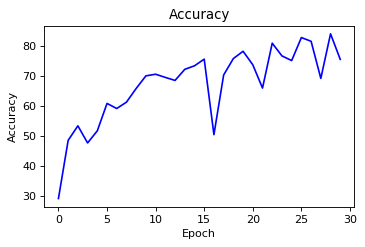

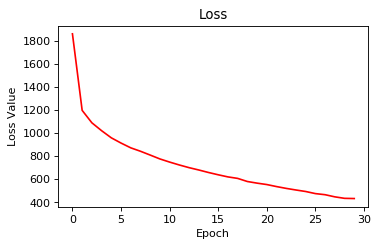

In [22]:
figure(figsize=(5, 3), dpi=80)
plt.title('Accuracy')

plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.plot(accuracies_train, color='b')

plt.show()

figure(figsize=(5, 3), dpi=80)
plt.title('Loss')
plt.xlabel("Epoch")
plt.ylabel("Loss Value")
plt.plot(total_loss, color='r')
plt.show()

# Evaluating the model with the test set:

In [23]:
test_accuracy = evaluate(model=model, data_loader=test_loader, device=device)

In [24]:
print(f'Test accuracy: {test_accuracy:.2f}%')

Test accuracy: 68.63%
